# 09 — Interpretabilidade: Grad-CAM






## Objetivo

Aplicar Grad-CAM (Gradient-weighted Class Activation Mapping) para
visualizar as regiões das imagens de raio-X que mais influenciam
as decisões dos modelos treinados.

A análise é realizada em dois modelos:
- ResNet18 Baseline (resnet18_light_noCW.pt)
- ResNet18 Class Weight (resnet18_light_CW.pt) — modelo defendido

Para cada modelo, são analisados:
- Verdadeiros Positivos (TP): Pneumonia corretamente identificada
- Verdadeiros Negativos (TN): Normal corretamente identificado
- Falsos Negativos (FN): Pneumonia classificada como Normal
- Falsos Positivos (FP): Normal classificado como Pneumonia

Arquivos gerados:
- outputs/figures/gradcam/baseline_TP.png
- outputs/figures/gradcam/baseline_FN.png
- outputs/figures/gradcam/cw_TP.png
- outputs/figures/gradcam/cw_FN.png
- outputs/figures/gradcam/comparacao_modelos.png


## 1. Setup e Imports

In [2]:
import os

NOTEBOOK_DIR = os.getcwd()
PROJECT_ROOT = os.path.abspath(os.path.join(NOTEBOOK_DIR, ".."))

print("Project root:", PROJECT_ROOT)

Project root: c:\projects\xray-project


In [3]:
import sys
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import cv2
from PIL import Image

SRC_PATH = os.path.join(PROJECT_ROOT, "src")
if SRC_PATH not in sys.path:
    sys.path.append(SRC_PATH)

from model import get_model
from transforms import get_transforms
from dataset import XRayDataset
from utils import set_seed, create_directories
from torch.utils.data import DataLoader

set_seed(42)

In [4]:
_, _, gradcam_dir = create_directories(PROJECT_ROOT)
print("Grad-CAM output dir:", gradcam_dir)

Grad-CAM output dir: c:\projects\xray-project\outputs\figures\gradcam


## 2. Implementação do Grad-CAM

O Grad-CAM utiliza os gradientes da classe alvo em relação aos
mapas de ativação da última camada convolucional para gerar um
mapa de calor (heatmap) que destaca as regiões mais relevantes
para a decisão do modelo.



In [5]:
class GradCAM:
    """
    Implementação de Grad-CAM compatível com ResNet18 e DenseNet121.

    Parâmetros:
        model: modelo PyTorch já carregado
        target_layer: camada convolucional alvo para extração dos gradientes
    """

    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self._register_hooks()

    def _register_hooks(self):
        """Registra hooks para capturar ativações e gradientes."""

        def forward_hook(module, input, output):
            self.activations = output.detach()

        def backward_hook(module, grad_input, grad_output):
            self.gradients = grad_output[0].detach()

        self.target_layer.register_forward_hook(forward_hook)
        self.target_layer.register_full_backward_hook(backward_hook)

    def generate(self, input_tensor, target_class=None):
        """
        Gera o heatmap Grad-CAM para a imagem de entrada.

        Parâmetros:
            input_tensor: tensor da imagem (1, C, H, W)
            target_class: classe alvo (None → usa a predita)

        Retorno:
            heatmap (np.array): mapa de calor normalizado [0, 1]
            pred_class (int): classe predita
            pred_prob (float): probabilidade da classe positiva
        """
        self.model.eval()
        input_tensor = input_tensor.requires_grad_(True)

        # Forward pass
        output = self.model(input_tensor)
        probs = torch.softmax(output, dim=1)
        pred_class = output.argmax(dim=1).item()
        pred_prob = probs[0, 1].item()  # prob da classe Pneumonia

        if target_class is None:
            target_class = pred_class

        # Backward pass
        self.model.zero_grad()
        score = output[0, target_class]
        score.backward()

        # Gradientes e ativações
        gradients = self.gradients        # (1, C, H, W)
        activations = self.activations    # (1, C, H, W)

        # Pesos: média global dos gradientes por canal
        weights = gradients.mean(dim=(2, 3), keepdim=True)  # (1, C, 1, 1)

        # Mapa de ativação ponderado
        cam = (weights * activations).sum(dim=1).squeeze()  # (H, W)
        cam = torch.relu(cam)

        # Normalização
        cam = cam.cpu().numpy()
        if cam.max() > 0:
            cam = cam / cam.max()

        return cam, pred_class, pred_prob

## 3. Funções Auxiliares de Visualização

In [6]:
def overlay_heatmap(original_img_pil, cam, alpha=0.4):
    """
    Sobrepõe o heatmap Grad-CAM na imagem original.

    Parâmetros:
        original_img_pil: imagem PIL original (sem normalização)
        cam: heatmap numpy [0, 1]
        alpha: intensidade da sobreposição

    Retorno:
        overlay: imagem numpy com heatmap sobreposto (H, W, 3)
    """
    # Converter para numpy RGB
    img_np = np.array(original_img_pil.convert("RGB"))
    h, w = img_np.shape[:2]

    # Redimensionar heatmap para o tamanho da imagem original
    cam_resized = cv2.resize(cam, (w, h))

    # Aplicar colormap JET
    heatmap = cv2.applyColorMap(
        np.uint8(255 * cam_resized),
        cv2.COLORMAP_JET
    )
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)

    # Blend
    overlay = (alpha * heatmap + (1 - alpha) * img_np).astype(np.uint8)

    return overlay


def get_label_name(label):
    return "Pneumonia" if label == 1 else "Normal"


def get_pred_name(pred_class):
    return "Pneumonia" if pred_class == 1 else "Normal"

In [7]:
def plot_gradcam_grid(samples, gradcam, val_transform, title, save_path, n_cols=4):
    """
    Plota uma grade de imagens com Grad-CAM sobreposto.

    Cada coluna mostra: Imagem Original | Grad-CAM

    Parâmetros:
        samples: lista de dicts com 'path', 'label'
        gradcam: instância do GradCAM já configurada
        val_transform: transformação de validação
        title: título geral da figura
        save_path: caminho para salvar
        n_cols: número de exemplos por linha
    """
    n = len(samples)
    fig, axes = plt.subplots(n, 2, figsize=(10, 4.5 * n))

    if n == 1:
        axes = [axes]

    fig.suptitle(title, fontsize=15, fontweight='bold', y=1.01)

    for i, sample in enumerate(samples):
        path = sample["path"]
        true_label = sample["label"]

        # Imagem original (sem transforms)
        original_pil = Image.open(path).convert("RGB")

        # Tensor para o modelo
        tensor = val_transform(original_pil).unsqueeze(0)

        # Grad-CAM
        cam, pred_class, pred_prob = gradcam.generate(tensor)

        # Overlay
        overlay = overlay_heatmap(original_pil, cam, alpha=0.4)

        # Determinar cor do título
        correct = (pred_class == true_label)
        color = "green" if correct else "red"

        # Plot original
        axes[i][0].imshow(original_pil, cmap="gray")
        axes[i][0].set_title(
            f"Original\nReal: {get_label_name(true_label)}",
            fontsize=11
        )
        axes[i][0].axis("off")

        # Plot Grad-CAM
        axes[i][1].imshow(overlay)
        axes[i][1].set_title(
            f"Grad-CAM\nPredito: {get_pred_name(pred_class)} (p={pred_prob:.2f})",
            fontsize=11,
            color=color
        )
        axes[i][1].axis("off")

    plt.tight_layout()
    plt.savefig(save_path, dpi=150, bbox_inches="tight")
    plt.show()
    print(f"Salvo em: {save_path}")

## 4. Carregamento dos Dados de Validação

In [8]:
metadata_dir = os.path.join(PROJECT_ROOT, "data", "metadata")
val_df = pd.read_csv(os.path.join(metadata_dir, "val_split.csv"))

print(f"Validação: {len(val_df)} imagens")
print(f"Normal:    {(val_df['label'] == 0).sum()}")
print(f"Pneumonia: {(val_df['label'] == 1).sum()}")

Validação: 1139 imagens
Normal:    267
Pneumonia: 872


In [9]:
_, val_transform = get_transforms(img_size=224, augmentation="light")

## 5. Função de Predição em Lote

Roda o modelo em todo o conjunto de validação para identificar
TPs, TNs, FPs e FNs de forma sistemática.

In [10]:
def predict_all(model, val_df, val_transform, device, threshold=0.5):
    """
    Roda o modelo em toda a validação e retorna um DataFrame
    com os resultados por imagem.

    Retorno:
        results_df com colunas: path, label, pred_class, pred_prob
    """
    model.eval()
    results = []

    with torch.no_grad():
        for _, row in val_df.iterrows():
            img = Image.open(row["path"]).convert("RGB")
            tensor = val_transform(img).unsqueeze(0).to(device)

            output = model(tensor)
            prob = torch.softmax(output, dim=1)[0, 1].item()
            pred = 1 if prob >= threshold else 0

            results.append({
                "path": row["path"],
                "label": row["label"],
                "pred_class": pred,
                "pred_prob": prob
            })

    return pd.DataFrame(results)


def sample_cases(results_df, n=3):
    """
    Seleciona n exemplos aleatórios de cada categoria
    (TP, TN, FP, FN).
    """
    tp = results_df[(results_df["label"] == 1) & (results_df["pred_class"] == 1)].sample(min(n, len(results_df[(results_df["label"] == 1) & (results_df["pred_class"] == 1)])), random_state=42)
    tn = results_df[(results_df["label"] == 0) & (results_df["pred_class"] == 0)].sample(min(n, len(results_df[(results_df["label"] == 0) & (results_df["pred_class"] == 0)])), random_state=42)
    fp = results_df[(results_df["label"] == 0) & (results_df["pred_class"] == 1)]
    fn = results_df[(results_df["label"] == 1) & (results_df["pred_class"] == 0)]

    # Para FP e FN, pegar todos se houver menos que n
    fp = fp.sample(min(n, len(fp)), random_state=42) if len(fp) > 0 else fp
    fn = fn.sample(min(n, len(fn)), random_state=42) if len(fn) > 0 else fn

    print(f"TP: {len(tp)} | TN: {len(tn)} | FP: {len(fp)} | FN: {len(fn)}")
    return tp, tn, fp, fn

## 6. Grad-CAM — Baseline (ResNet18 sem Class Weight)

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
models_dir = os.path.join(PROJECT_ROOT, "models")

# Carregar modelo Baseline
baseline_model, baseline_target_layer = get_model(model_name="resnet18")
baseline_model.load_state_dict(
    torch.load(
        os.path.join(models_dir, "resnet18_light_noCW.pt"),
        map_location=device
    )
)
baseline_model = baseline_model.to(device)
baseline_model.eval()

print("Baseline carregado.")

c:\Users\honor\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\honor\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Baseline carregado.


In [12]:
gradcam_baseline = GradCAM(baseline_model, baseline_target_layer)

print("Rodando predições no conjunto de validação...")
results_baseline = predict_all(baseline_model, val_df, val_transform, device)

tp_b, tn_b, fp_b, fn_b = sample_cases(results_baseline, n=3)

Rodando predições no conjunto de validação...
TP: 3 | TN: 3 | FP: 3 | FN: 3


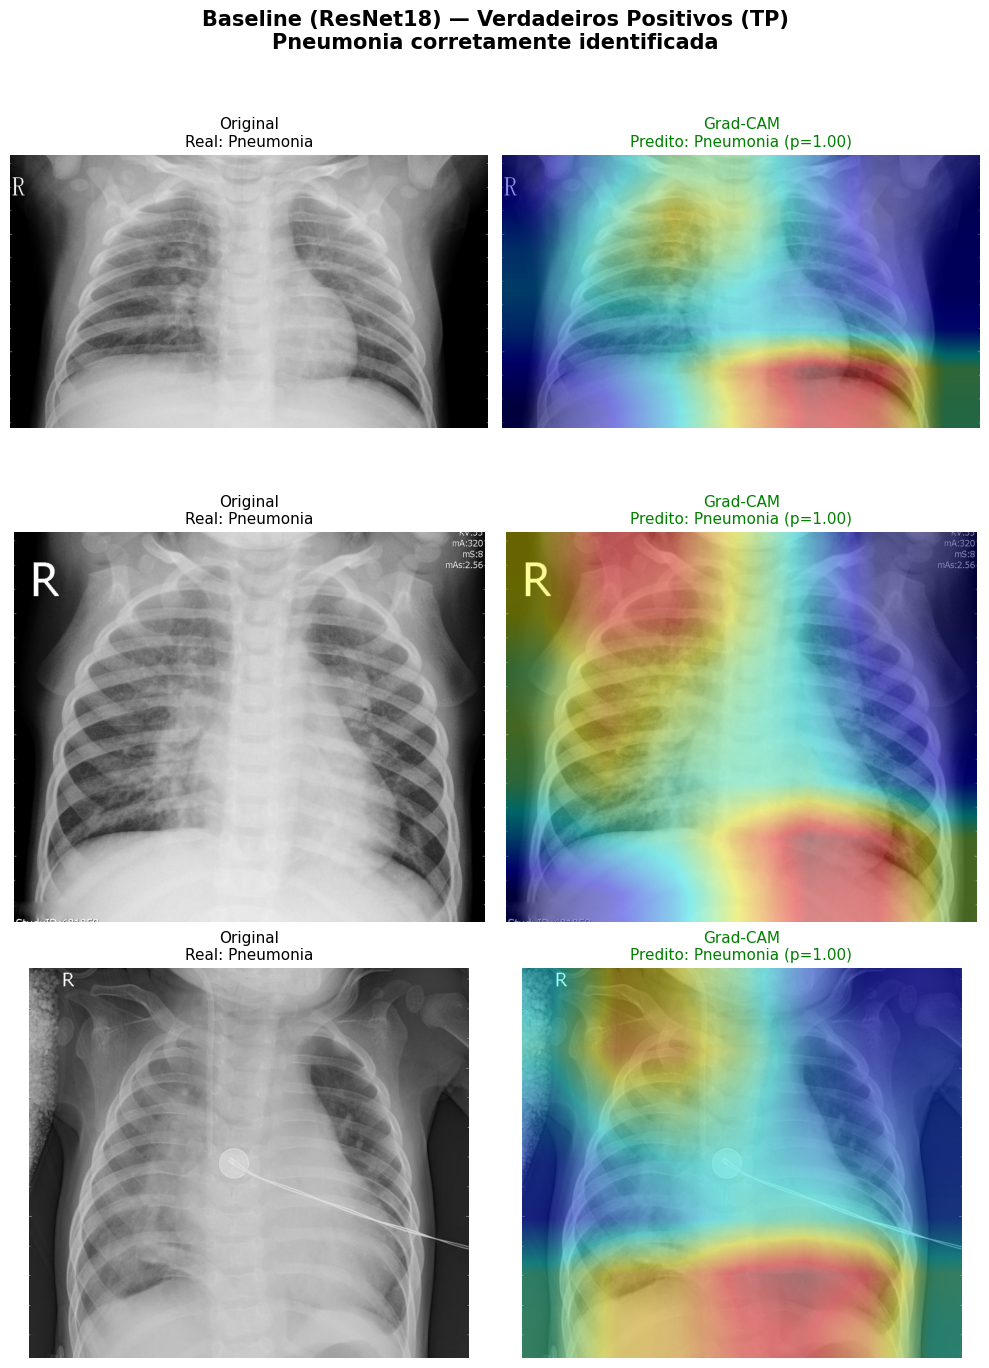

Salvo em: c:\projects\xray-project\outputs\figures\gradcam\baseline_TP.png


In [13]:
# --- Verdadeiros Positivos (Baseline) ---
plot_gradcam_grid(
    samples=tp_b.to_dict("records"),
    gradcam=gradcam_baseline,
    val_transform=val_transform,
    title="Baseline (ResNet18) — Verdadeiros Positivos (TP)\nPneumonia corretamente identificada",
    save_path=os.path.join(gradcam_dir, "baseline_TP.png")
)

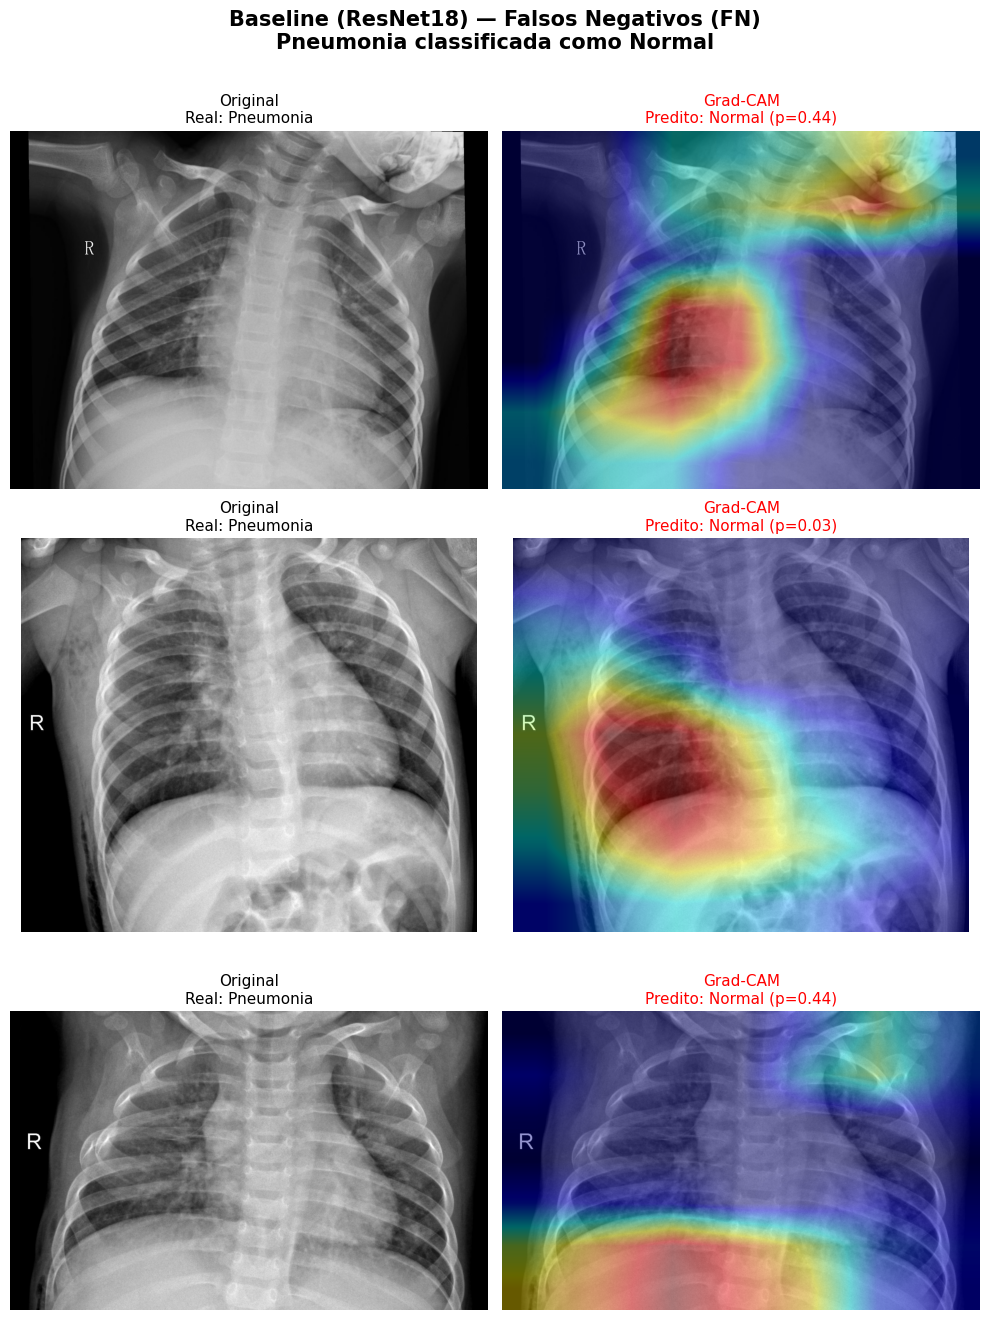

Salvo em: c:\projects\xray-project\outputs\figures\gradcam\baseline_FN.png


In [14]:
# --- Falsos Negativos (Baseline) ---
# Casos críticos: pneumonia não detectada → risco clínico
if len(fn_b) > 0:
    plot_gradcam_grid(
        samples=fn_b.to_dict("records"),
        gradcam=gradcam_baseline,
        val_transform=val_transform,
        title="Baseline (ResNet18) — Falsos Negativos (FN)\nPneumonia classificada como Normal",
        save_path=os.path.join(gradcam_dir, "baseline_FN.png")
    )
else:
    print("Nenhum FN encontrado para o Baseline.")

O FN indicado para o baseline é mais próximo de 0.5 (indicando mais incerteza na predição), além de as áreas serem mais concentradas, enquanto nos FN do CW são mais difusas.

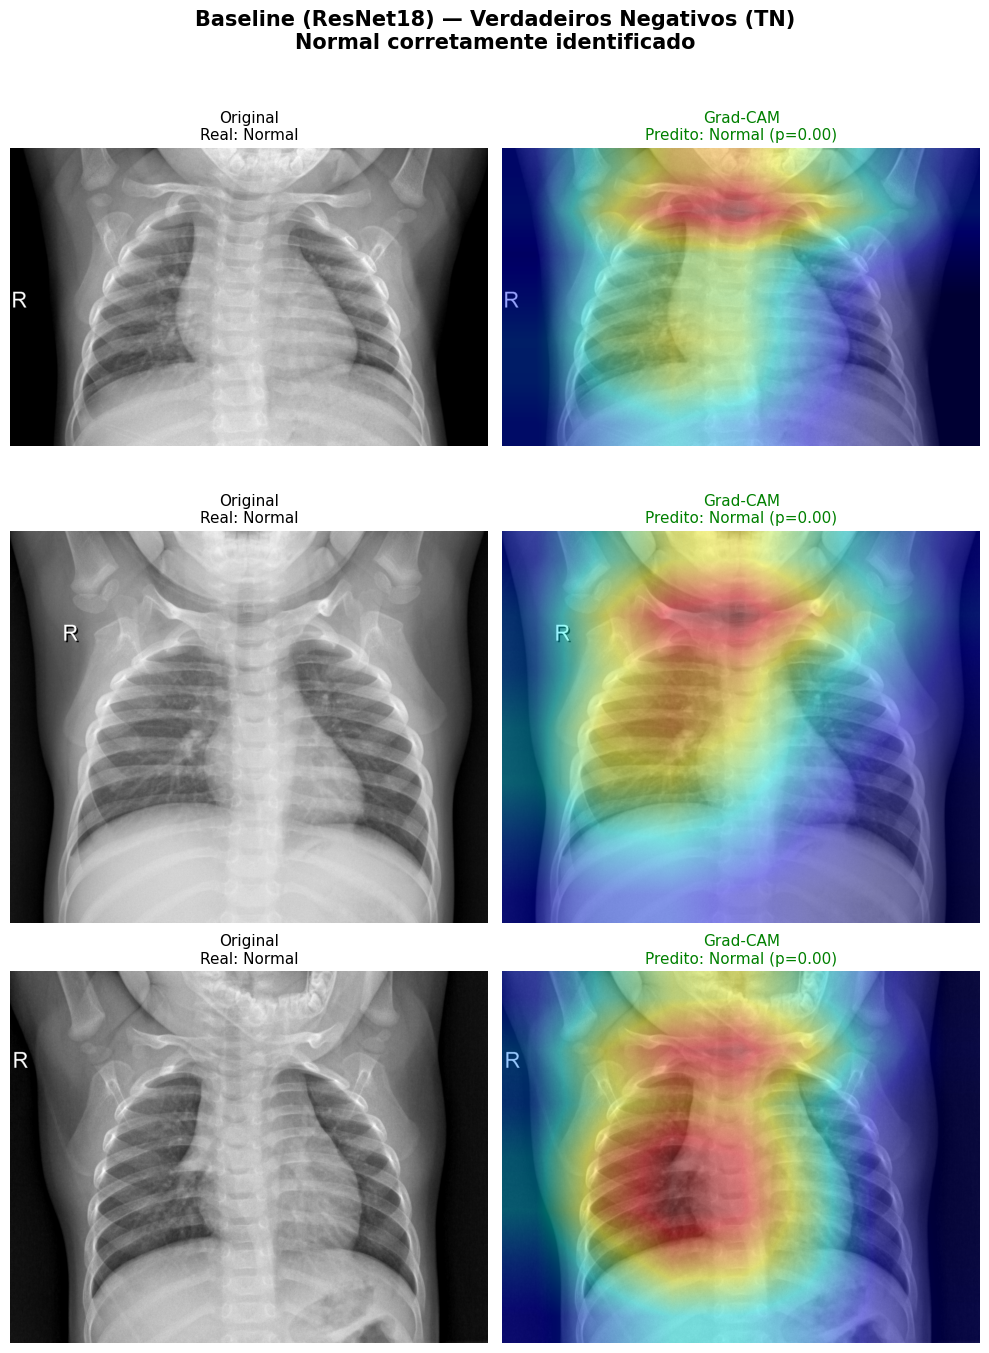

Salvo em: c:\projects\xray-project\outputs\figures\gradcam\baseline_TN.png


In [15]:
# --- Verdadeiros Negativos (Baseline) ---
plot_gradcam_grid(
    samples=tn_b.to_dict("records"),
    gradcam=gradcam_baseline,
    val_transform=val_transform,
    title="Baseline (ResNet18) — Verdadeiros Negativos (TN)\nNormal corretamente identificado",
    save_path=os.path.join(gradcam_dir, "baseline_TN.png")
)

Os heatmaps de TNs estão ativando bastante a região do mediastino e coluna vertebral — isso é esperado em imagens normais, pois o modelo aprende que pulmões limpos e coluna bem definida são indicadores de ausência de patologia.

## 7. Grad-CAM — Class Weight (ResNet18 com Ponderação de Classes)

Este modelo é o defendido no relatório por apresentar
menor número de Falsos Negativos (5 vs 16 do Baseline),
métrica de maior relevância clínica.

In [16]:
# Carregar modelo Class Weight
cw_model, cw_target_layer = get_model(model_name="resnet18")
cw_model.load_state_dict(
    torch.load(
        os.path.join(models_dir, "resnet18_light_CW.pt"),
        map_location=device
    )
)
cw_model = cw_model.to(device)
cw_model.eval()

print("Class Weight carregado.")

c:\Users\honor\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\honor\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Class Weight carregado.


In [17]:
gradcam_cw = GradCAM(cw_model, cw_target_layer)

print("Rodando predições no conjunto de validação...")
results_cw = predict_all(cw_model, val_df, val_transform, device)

tp_cw, tn_cw, fp_cw, fn_cw = sample_cases(results_cw, n=3)

Rodando predições no conjunto de validação...
TP: 3 | TN: 3 | FP: 3 | FN: 3


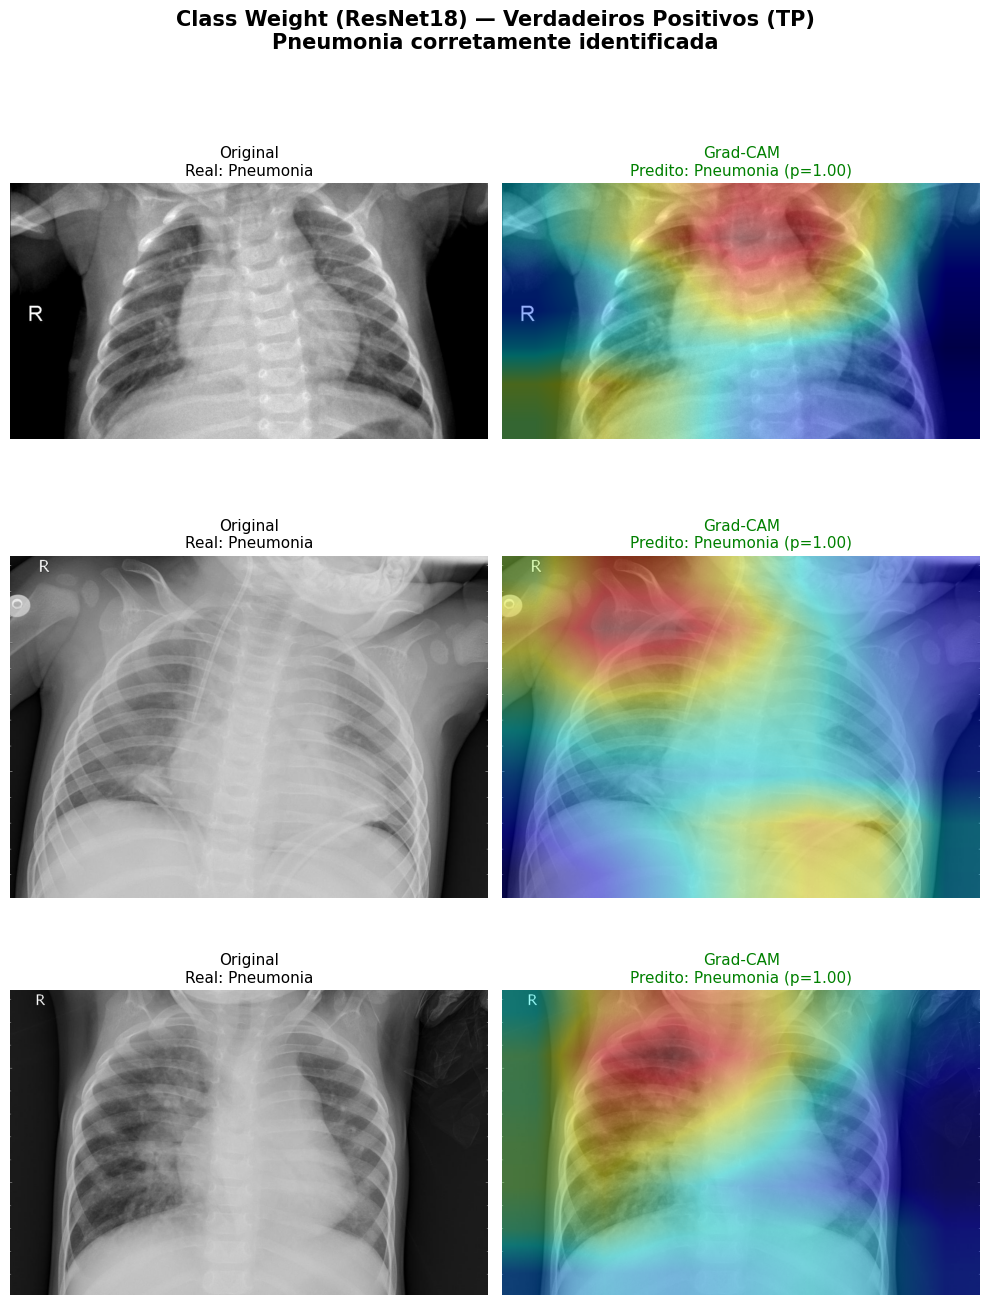

Salvo em: c:\projects\xray-project\outputs\figures\gradcam\cw_TP.png


In [18]:
# --- Verdadeiros Positivos (CW) ---
plot_gradcam_grid(
    samples=tp_cw.to_dict("records"),
    gradcam=gradcam_cw,
    val_transform=val_transform,
    title="Class Weight (ResNet18) — Verdadeiros Positivos (TP)\nPneumonia corretamente identificada",
    save_path=os.path.join(gradcam_dir, "cw_TP.png")
)

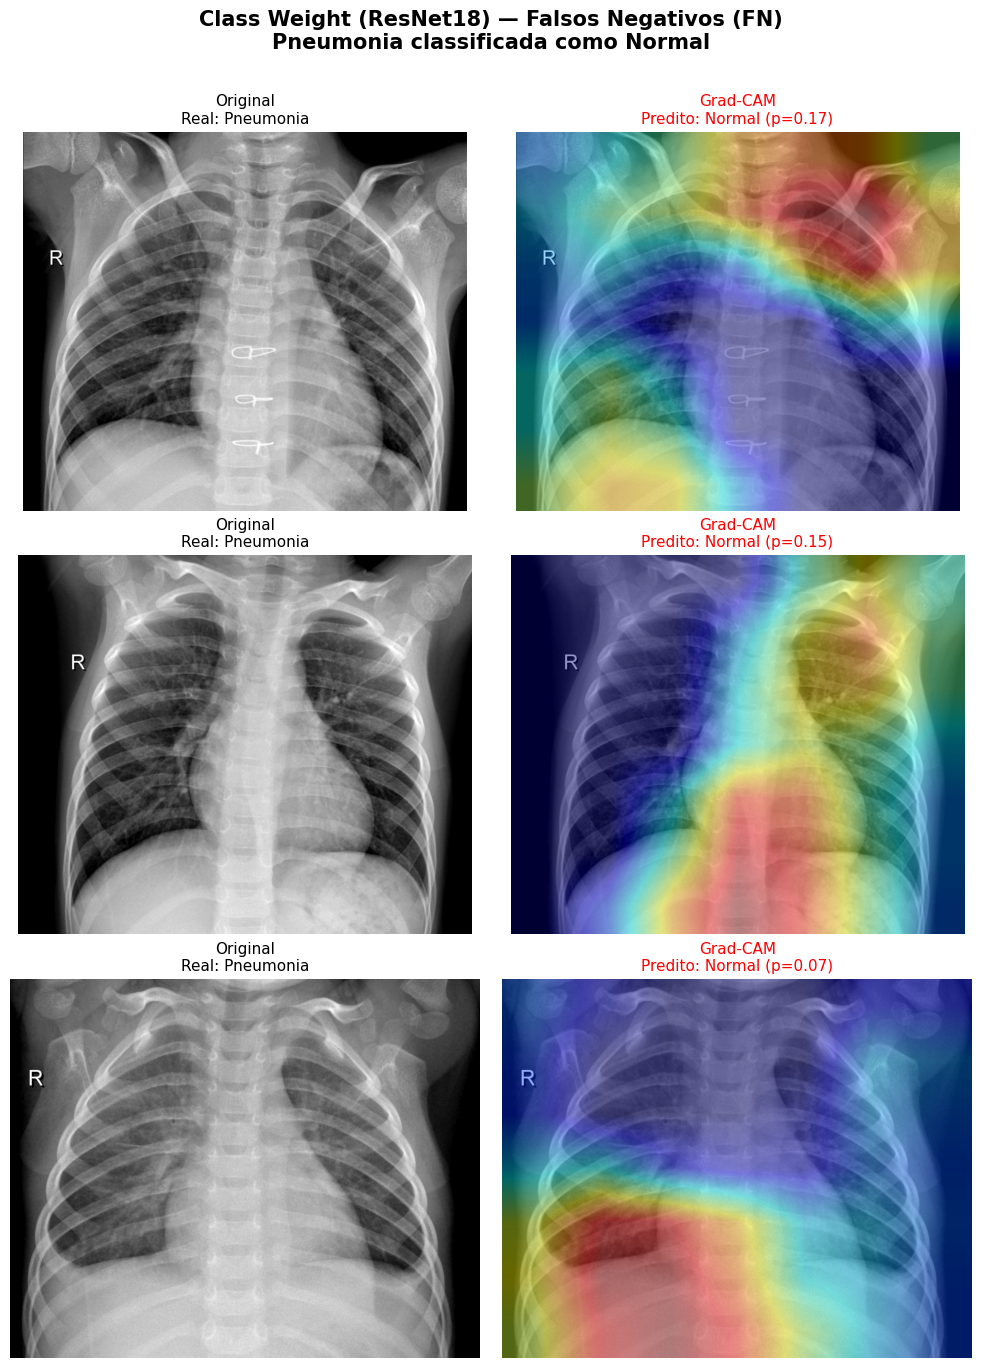

Salvo em: c:\projects\xray-project\outputs\figures\gradcam\cw_FN.png


In [19]:
# --- Falsos Negativos (CW) ---
# Espera-se menos FNs do que no Baseline
if len(fn_cw) > 0:
    plot_gradcam_grid(
        samples=fn_cw.to_dict("records"),
        gradcam=gradcam_cw,
        val_transform=val_transform,
        title="Class Weight (ResNet18) — Falsos Negativos (FN)\nPneumonia classificada como Normal",
        save_path=os.path.join(gradcam_dir, "cw_FN.png")
    )
else:
    print("Nenhum FN encontrado para o modelo Class Weight.")

CW possui incerteza calibrada, uma vez que os FNs apresentam baixa probabilidade. É possível analisar o mapa mais difuso na classificação.

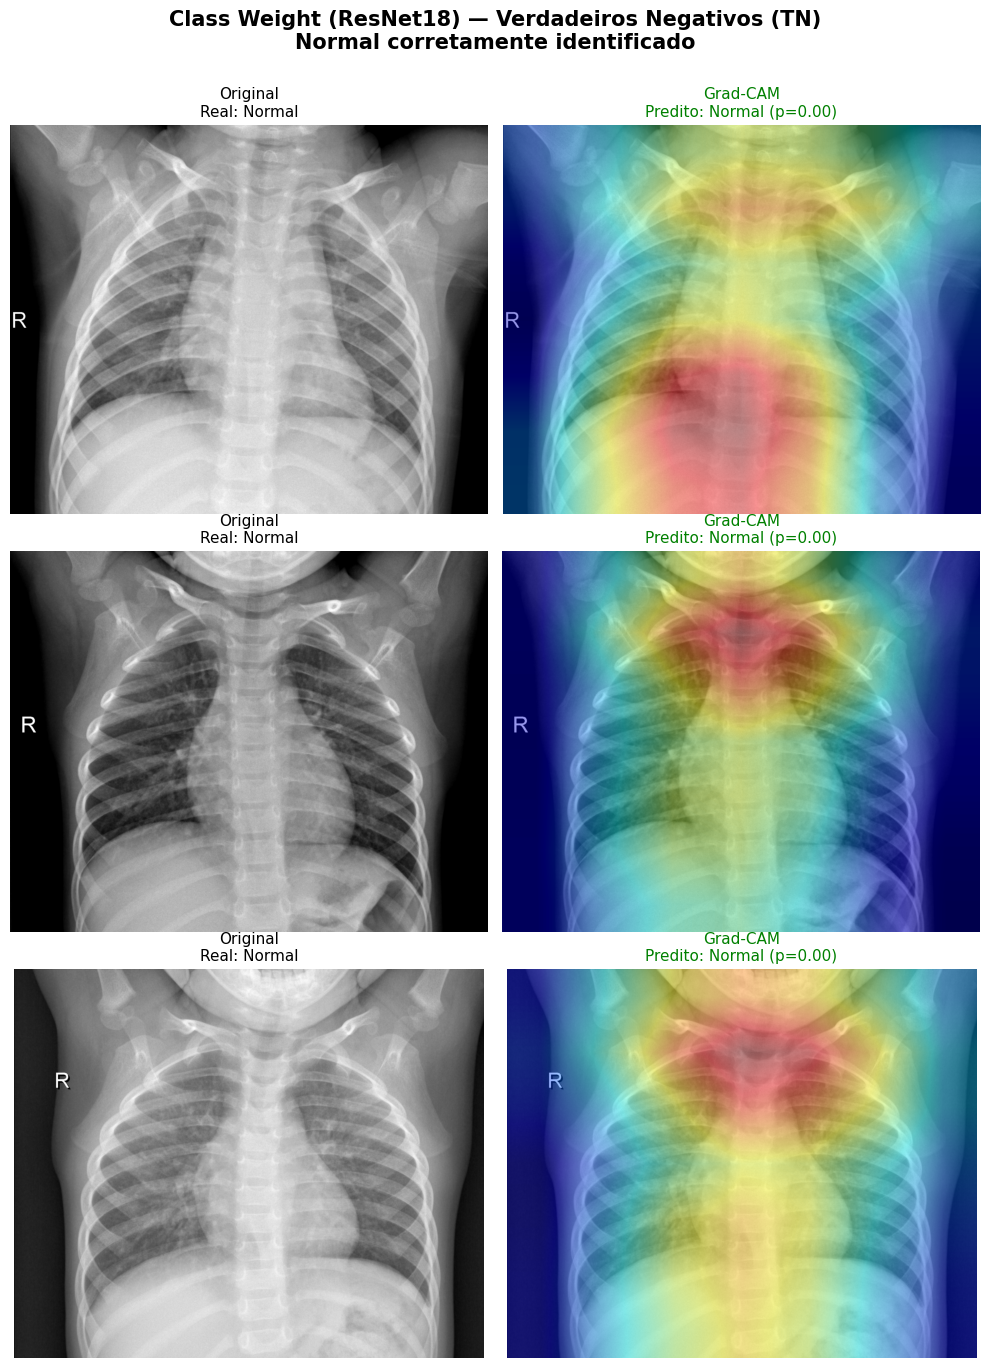

Salvo em: c:\projects\xray-project\outputs\figures\gradcam\cw_TN.png


In [20]:
# --- Verdadeiros Negativos (CW) ---
plot_gradcam_grid(
    samples=tn_cw.to_dict("records"),
    gradcam=gradcam_cw,
    val_transform=val_transform,
    title="Class Weight (ResNet18) — Verdadeiros Negativos (TN)\nNormal corretamente identificado",
    save_path=os.path.join(gradcam_dir, "cw_TN.png")
)

Os heatmaps de TNs estão ativando bastante a região do mediastino e coluna vertebral: isso é esperado em imagens normais, pois o modelo aprende que pulmões limpos e coluna bem definida são indicadores de ausência de patologia.  nas imagens de TN do CW, as probabilidades mostram p=0.00 — isso pode ser arredondamento do display ou os modelos estão muito confiantes nas normais. Não é problema, mas vale mencionar que o modelo é bem calibrado para a classe negativa.

## 8. Comparação Direta: Baseline vs Class Weight

Visualização lado a lado das mesmas imagens nos dois modelos.

Objetivo: verificar se o modelo Class Weight foca em regiões
anatomicamente mais plausíveis (regiões pulmonares)
comparado ao Baseline.

In [21]:
def plot_comparison(samples, gradcam_a, gradcam_b, label_a, label_b,
                    val_transform, title, save_path):
    """
    Compara dois modelos lado a lado nas mesmas imagens.

    Colunas: Original | Grad-CAM Modelo A | Grad-CAM Modelo B
    """
    n = len(samples)
    fig, axes = plt.subplots(n, 3, figsize=(14, 4.5 * n))

    if n == 1:
        axes = [axes]

    fig.suptitle(title, fontsize=14, fontweight='bold', y=1.01)

    for i, sample in enumerate(samples):
        path = sample["path"]
        true_label = sample["label"]

        original_pil = Image.open(path).convert("RGB")
        tensor = val_transform(original_pil).unsqueeze(0)

        # Grad-CAM dos dois modelos
        cam_a, pred_a, prob_a = gradcam_a.generate(tensor)
        cam_b, pred_b, prob_b = gradcam_b.generate(tensor)

        overlay_a = overlay_heatmap(original_pil, cam_a)
        overlay_b = overlay_heatmap(original_pil, cam_b)

        # Original
        axes[i][0].imshow(original_pil, cmap="gray")
        axes[i][0].set_title(f"Original\nReal: {get_label_name(true_label)}", fontsize=10)
        axes[i][0].axis("off")

        # Modelo A
        color_a = "green" if pred_a == true_label else "red"
        axes[i][1].imshow(overlay_a)
        axes[i][1].set_title(
            f"{label_a}\nPredito: {get_pred_name(pred_a)} (p={prob_a:.2f})",
            fontsize=10, color=color_a
        )
        axes[i][1].axis("off")

        # Modelo B
        color_b = "green" if pred_b == true_label else "red"
        axes[i][2].imshow(overlay_b)
        axes[i][2].set_title(
            f"{label_b}\nPredito: {get_pred_name(pred_b)} (p={prob_b:.2f})",
            fontsize=10, color=color_b
        )
        axes[i][2].axis("off")

    plt.tight_layout()
    plt.savefig(save_path, dpi=150, bbox_inches="tight")
    plt.show()
    print(f"Salvo em: {save_path}")

Casos onde Baseline errou e CW acertou: 12


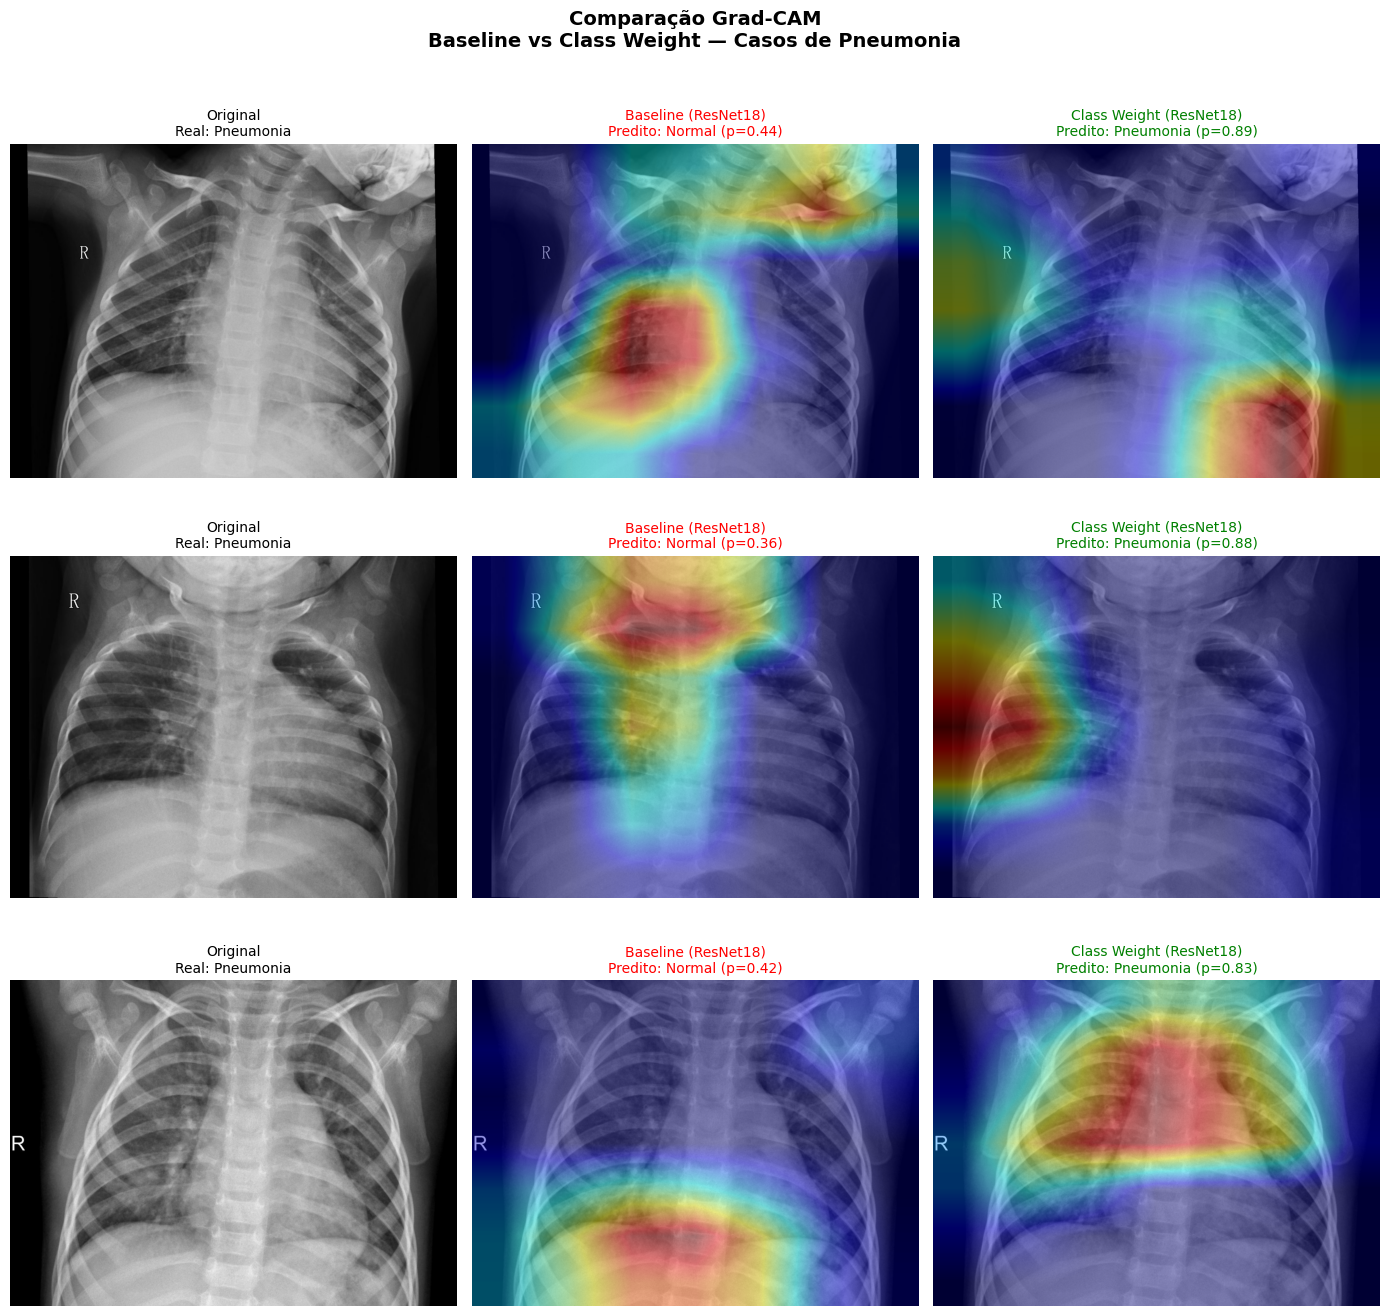

Salvo em: c:\projects\xray-project\outputs\figures\gradcam\comparacao_modelos.png


In [22]:
# Selecionar imagens de pneumonia presentes nos dois conjuntos
# para comparação (FNs do Baseline que o CW acertou)

# Merge para identificar casos onde Baseline errou e CW acertou
merged = results_baseline.merge(
    results_cw[["path", "pred_class", "pred_prob"]],
    on="path",
    suffixes=("_baseline", "_cw")
)

# Baseline FN + CW TP: casos clinicamente relevantes
interesting = merged[
    (merged["label"] == 1) &
    (merged["pred_class_baseline"] == 0) &
    (merged["pred_class_cw"] == 1)
]

print(f"Casos onde Baseline errou e CW acertou: {len(interesting)}")

if len(interesting) >= 1:
    comparison_samples = interesting.head(3)[["path", "label"]].to_dict("records")
else:
    # Fallback: usar TPs de pneumonia em geral
    print("Usando TPs de pneumonia para comparação geral.")
    comparison_samples = tp_b.head(3)[["path", "label"]].to_dict("records")

plot_comparison(
    samples=comparison_samples,
    gradcam_a=gradcam_baseline,
    gradcam_b=gradcam_cw,
    label_a="Baseline (ResNet18)",
    label_b="Class Weight (ResNet18)",
    val_transform=val_transform,
    title="Comparação Grad-CAM\nBaseline vs Class Weight — Casos de Pneumonia",
    save_path=os.path.join(gradcam_dir, "comparacao_modelos.png")
)

Ao analisar imagens de pulmões com pneumonia preditas como normais para o baseline e afetadas pelo CW, é possível observar que o baseline foca em regiões do mediastino ou bordas superiores enquanto o CW desloca sua zona "quente" preedominantemente para o parênquima pulmonar.

## 9. Resumo dos Resultados

Tabela comparativa dos dois modelos analisados.

In [23]:
def summarize_predictions(results_df, model_name):
    tp = ((results_df["label"] == 1) & (results_df["pred_class"] == 1)).sum()
    tn = ((results_df["label"] == 0) & (results_df["pred_class"] == 0)).sum()
    fp = ((results_df["label"] == 0) & (results_df["pred_class"] == 1)).sum()
    fn = ((results_df["label"] == 1) & (results_df["pred_class"] == 0)).sum()

    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    accuracy = (tp + tn) / len(results_df)

    print(f"\n{'='*45}")
    print(f"Modelo: {model_name}")
    print(f"{'='*45}")
    print(f"  TP (Pneumonia correta):  {tp}")
    print(f"  TN (Normal correta):     {tn}")
    print(f"  FP (Normal → Pneumonia): {fp}")
    print(f"  FN (Pneumonia → Normal): {fn}  ← relevância clínica")
    print(f"  Sensitivity (Recall):    {sensitivity:.4f}")
    print(f"  Specificity:             {specificity:.4f}")
    print(f"  Accuracy:                {accuracy:.4f}")

summarize_predictions(results_baseline, "ResNet18 Baseline")
summarize_predictions(results_cw, "ResNet18 Class Weight")


Modelo: ResNet18 Baseline
  TP (Pneumonia correta):  856
  TN (Normal correta):     263
  FP (Normal → Pneumonia): 4
  FN (Pneumonia → Normal): 16  ← relevância clínica
  Sensitivity (Recall):    0.9817
  Specificity:             0.9850
  Accuracy:                0.9824

Modelo: ResNet18 Class Weight
  TP (Pneumonia correta):  867
  TN (Normal correta):     260
  FP (Normal → Pneumonia): 7
  FN (Pneumonia → Normal): 5  ← relevância clínica
  Sensitivity (Recall):    0.9943
  Specificity:             0.9738
  Accuracy:                0.9895
